# Discover age-associated genes

In this notebook, we download the GTEX whole-blood dataset and explore which genes are most closely associated with age. Most of the EDA follows the previous analysis on sex-associated genes, and codes are mostly adopted from RJ's demo.

In [181]:
import pandas as pd
from pathlib import Path
import requests
import gzip
import shutil

download_directory_path = Path.cwd() / "data" # change this based on your directory; I removed .parent() after .cwd()


def download_if_not_exists(url: str, download_dir: Path = download_directory_path) -> Path:
    """
    Download a file from a URL to the specified directory if it doesn't exist.
    
    Args:
        url: URL to download from
        download_dir: Directory to save the file in
    
    Returns:
        Path to the downloaded file
    """
    download_dir.mkdir(exist_ok=True)
    file_path = download_dir / Path(url).name
    
    if not file_path.exists():
        print(f"Downloading {file_path.name}...")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        
        with open(file_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download complete!")
    else:
        print(f"File already exists at {file_path}")
    
    return file_path

def ungzip_if_not_exists(gzip_path: Path) -> Path:
    """
    Ungzip a file if the unzipped version doesn't exist.
    
    Args:
        gzip_path: Path to the gzipped file
    
    Returns:
        Path to the unzipped file
    """
    unzipped_path = gzip_path.parent / gzip_path.stem
    
    if not unzipped_path.exists():
        print(f"Unzipping to {unzipped_path}...")
        with gzip.open(gzip_path, 'rb') as f_in:
            with open(unzipped_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print("Unzipping complete!")
    else:
        print(f"Unzipped file already exists at {unzipped_path}")
    
    return unzipped_path

def load_data(url: str, download_dir: Path = download_directory_path) -> pd.DataFrame:
    """
    Download (if needed), unzip (if needed), and load data into a pandas DataFrame.
    Handles special case for GCT files by reading their headers first.
    Uses existing download_if_not_exists and ungzip_if_not_exists functions.
    
    Args:
        url: URL to download from
        download_dir: Directory to save the file in
    
    Returns:
        pandas DataFrame with the loaded data
    """
    # Use existing function to download
    file_path = download_if_not_exists(url, download_dir)
    
    # Use existing function to unzip if needed
    if file_path.suffix == '.gz':
        file_path = ungzip_if_not_exists(file_path)
    
    # Handle GCT files specially
    if file_path.suffix == '.gct':
        print("Reading GCT file header...")
        with open(file_path, 'r') as f:
            version = f.readline().strip()
            dims = f.readline().strip().split('\t')
            print(f"GCT version: {version}")
            print(f"Dimensions: {dims}")
        
        df = pd.read_csv(file_path,
                        sep='\t',
                        skiprows=2,
                        index_col=0)
    else:
        # For regular TSV files
        df = pd.read_csv(file_path,
                        sep='\t',
                        index_col=0)
    
    print(f"\nLoaded dataset shape: {df.shape}")
    return df

In [182]:
gtex_whole_blood_url = "https://storage.googleapis.com/adult-gtex/bulk-gex/v8/rna-seq/tpms-by-tissue/gene_tpm_2017-06-05_v8_whole_blood.gct.gz"
gtex_sample_attributes_url = "https://storage.googleapis.com/adult-gtex/annotations/v8/metadata-files/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt"
gtex_subject_phenotypes_url = "https://storage.googleapis.com/adult-gtex/annotations/v8/metadata-files/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt"

gtex_whole_blood_pdf = load_data(gtex_whole_blood_url)
gtex_sample_attributes_pdf = load_data(gtex_sample_attributes_url)
gtex_subject_phenotypes_pdf = load_data(gtex_subject_phenotypes_url)


File already exists at /Users/xiaoqianliu/Documents/Research/Multiomics/data/gene_tpm_2017-06-05_v8_whole_blood.gct.gz
Unzipped file already exists at /Users/xiaoqianliu/Documents/Research/Multiomics/data/gene_tpm_2017-06-05_v8_whole_blood.gct
Reading GCT file header...
GCT version: #1.3
Dimensions: ['56200', '757', '0', '0']

Loaded dataset shape: (56200, 757)
File already exists at /Users/xiaoqianliu/Documents/Research/Multiomics/data/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt

Loaded dataset shape: (22951, 62)
File already exists at /Users/xiaoqianliu/Documents/Research/Multiomics/data/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt

Loaded dataset shape: (980, 3)


In [183]:
gtex_subject_phenotypes_pdf.AGE

SUBJID
GTEX-1117F    60-69
GTEX-111CU    50-59
GTEX-111FC    60-69
GTEX-111VG    60-69
GTEX-111YS    60-69
              ...  
GTEX-ZYY3     60-69
GTEX-ZZ64     20-29
GTEX-ZZPT     50-59
GTEX-ZZPU     50-59
K-562         50-59
Name: AGE, Length: 980, dtype: object

## Lets take a peek

In [184]:
# 56200 genes and 757 samples; we take a look at the first five genes
gtex_whole_blood_pdf.head()

,Name,Description,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117XS-0005-SM-5PNU6,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,...,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
id,,,,,,,,,,,,,,,,,,,,,
0,ENSG00000223972.5,DDX11L1,0.0217,0.0301,0.0203,0.1675,0.021,0.0254,0.0249,0.0681,...,0.0000,0.0484,0.0000,0.000,0.0486,0.1145,0.0242,0.000,0.0213,0.0000
1,ENSG00000227232.5,WASH7P,1.5550,2.7470,4.4410,10.4700,1.287,3.1380,4.2170,2.0980,...,0.8979,3.0670,2.4640,1.504,3.1940,2.9060,3.4300,4.169,2.7430,6.0720
2,ENSG00000278267.1,MIR6859-1,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.6593,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.6112
3,ENSG00000243485.5,MIR1302-2HG,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0453,...,0.0000,0.0000,0.0000,0.000,0.0970,0.1143,0.0000,0.000,0.0000,0.0000
4,ENSG00000237613.2,FAM138A,0.0000,0.0000,0.0576,0.0000,0.000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0368,0.000,0.0000,0.0406,0.0000,0.000,0.0000,0.0000


In [185]:
gtex_whole_blood_pdf.describe()

,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117XS-0005-SM-5PNU6,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,GTEX-1192X-0005-SM-5NQC3,GTEX-11DXW-0006-SM-5NQ7Y,...,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
count,56200.000000,56200.000000,56200.000000,56200.000000,56200.000000,56200.000000,56200.000000,56200.000000,56200.000000,56200.000000,...,56200.000000,56200.000000,56200.000000,56200.000000,56200.000000,56200.000000,56200.000000,56200.000000,56200.000000,56200.000000
mean,17.794537,17.793619,17.792364,17.793490,17.793386,17.792640,17.794828,17.794302,17.792765,17.794426,...,17.794108,17.793754,17.794705,17.793275,17.793327,17.793359,17.793472,17.793396,17.793937,17.793941
std,1081.161119,587.092745,1056.083201,654.524008,1889.558379,1524.129507,1056.387860,1440.107773,3033.979748,734.351225,...,2370.234571,763.125824,1400.430075,1634.083758,892.602992,1256.701664,541.250303,1422.299039,1075.194903,657.646352
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.471800,0.751900,0.869075,1.621250,0.371100,0.269600,0.543000,0.471475,0.081650,0.896525,...,0.323000,0.731150,0.487600,0.509025,0.639750,0.737125,0.491200,0.523125,0.707500,0.829500
max,234900.000000,112900.000000,192600.000000,136200.000000,415100.000000,321400.000000,197300.000000,287200.000000,704500.000000,155000.000000,...,554200.000000,156000.000000,312300.000000,357000.000000,190000.000000,242900.000000,92390.000000,307300.000000,232400.000000,137700.000000


In [75]:
gtex_whole_blood_pdf.transpose().describe()

id,0,1,2,3,4,5,6,7,8,9,...,56190,56191,56192,56193,56194,56195,56196,56197,56198,56199
count,757.0,757.000,757.0,757.0,757.0,757.0,757.0,757.0,757.0,757.0,...,757.0,757.0,757.0,757.0,757.0,757.0,757.0,757.0,757.0,757.0
unique,291.0,702.000,26.0,119.0,93.0,164.0,223.0,231.0,616.0,725.0,...,727.0,288.0,165.0,264.0,726.0,710.0,687.0,704.0,255.0,306.0
top,0.0,2.251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4027.0,0.0,0.0,0.0,280.8,1162.0,0.0,1758.0,0.0,0.0
freq,396.0,3.000,732.0,630.0,645.0,573.0,481.0,476.0,86.0,3.0,...,2.0,463.0,592.0,492.0,3.0,3.0,49.0,3.0,498.0,438.0


In [186]:
# check the nnz for each sample
gtex_whole_blood_pdf.eq(0).sum()

Name                            0
Description                     0
GTEX-111YS-0006-SM-5NQBE    31729
GTEX-1122O-0005-SM-5O99J    30553
GTEX-1128S-0005-SM-5P9HI    28836
                            ...  
GTEX-ZVTK-0006-SM-57WBK     30504
GTEX-ZVZP-0006-SM-51MSW     31113
GTEX-ZVZQ-0006-SM-51MR8     29839
GTEX-ZXES-0005-SM-57WCB     29687
GTEX-ZXG5-0005-SM-57WCN     29762
Length: 757, dtype: int64

In [187]:
# What does this mean? Seems the number of samples, but why not 757?
gtex_sample_attributes_pdf.SMTSD.value_counts()

SMTSD
Whole Blood                                  3288
Muscle - Skeletal                            1132
Lung                                          867
Skin - Sun Exposed (Lower leg)                849
Thyroid                                       812
Artery - Tibial                               770
Adipose - Subcutaneous                        763
Nerve - Tibial                                722
Heart - Left Ventricle                        689
Skin - Not Sun Exposed (Suprapubic)           638
Esophagus - Mucosa                            622
Adipose - Visceral (Omentum)                  564
Esophagus - Muscularis                        559
Cells - Cultured fibroblasts                  527
Breast - Mammary Tissue                       480
Heart - Atrial Appendage                      452
Artery - Aorta                                450
Colon - Transverse                            432
Brain - Frontal Cortex (BA9)                  425
Testis                                      

In [188]:
gtex_sample_attributes_pdf.shape

(22951, 62)

In [189]:

gtex_sample_attributes_pdf.head()

,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,SMNABTCH,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0003-SM-58Q7G,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-5DWSB,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-6WBT7,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10a-SM-AHZ7F,NaN,"B1, A1",NaN,NaN,Brain,Brain - Frontal Cortex (BA9),0009834,1193.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10b-SM-CYKQ8,NaN,"B1, A1",NaN,7.2,Brain,Brain - Frontal Cortex (BA9),0009834,1193.0,NaN,BP-42319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 gtex_whole_blood_pdf

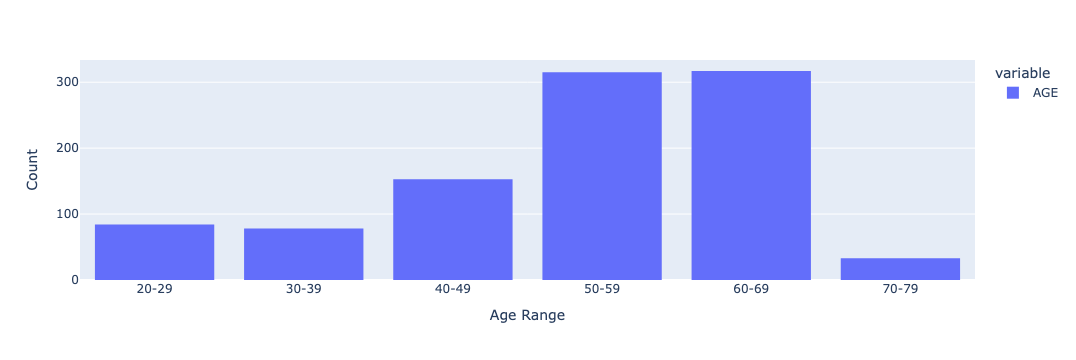

In [190]:
import plotly.express as px

# Define the correct order of age categories
age_order = ["20-29", "30-39", "40-49", "50-59", "60-69", "70-79"]

# Create the histogram with category ordering
fig = px.histogram(gtex_subject_phenotypes_pdf.AGE, 
                  category_orders={"value": age_order})

# Update layout if needed
fig.update_layout(
    xaxis_title="Age Range",
    yaxis_title="Count"
)

fig.show()

We don't actually need the sample attributes right now

In [191]:
# check details of the first r2 rows
# Ha, so many NAs
with pd.option_context('display.max_columns', None, 'display.width', None, 'display.max_colwidth', None):
  display(gtex_sample_attributes_pdf.head(2))

,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,SMNABTCH,SMNABTCHT,SMNABTCHD,SMGEBTCH,SMGEBTCHD,SMGEBTCHT,SMAFRZE,SMGTC,SME2MPRT,SMCHMPRS,SMNTRART,SMNUMGPS,SMMAPRT,SMEXNCRT,SM550NRM,SMGNSDTC,SMUNMPRT,SM350NRM,SMRDLGTH,SMMNCPB,SME1MMRT,SMSFLGTH,SMESTLBS,SMMPPD,SMNTERRT,SMRRNANM,SMRDTTL,SMVQCFL,SMMNCV,SMTRSCPT,SMMPPDPR,SMCGLGTH,SMGAPPCT,SMUNPDRD,SMNTRNRT,SMMPUNRT,SMEXPEFF,SMMPPDUN,SME2MMRT,SME2ANTI,SMALTALG,SME2SNSE,SMMFLGTH,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0003-SM-58Q7G,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,DNA isolation_Whole Blood_QIAGEN Puregene (Manual),05/02/2013,LCSET-4574,01/15/2014,Standard Exome Sequencing v3 (ICE),WES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-5DWSB,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,DNA isolation_Whole Blood_QIAGEN Puregene (Manual),05/02/2013,GTEx_OM25_Dec_01,01/28/2014,Illumina OMNI SNP Array,OMNI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Ok, lets build our dataframe

In [192]:
import numpy as np

gwbt_pdf = (
    gtex_whole_blood_pdf
    .drop(columns=["Name", "Description"])
    .apply(lambda x: np.log10(x + 1)) #Applies a log10 transformation column-wise
    .transpose()
)

gwbt_pdf.columns = gtex_whole_blood_pdf.Name
# Only use the first two parts as the subject id
gwbt_pdf['SUBJID'] = gwbt_pdf.index.map(lambda x: '-'.join(x.split('-')[:2])) 

gwbt_pdf = (
    gwbt_pdf
    .join(gtex_subject_phenotypes_pdf, on='SUBJID', how='left') # left join two subjects
    .drop(columns=["DTHHRDY", "SUBJID"]) # removed subjid.....
    
    # .join(gtex_sample_attributes_pdf, how='left')
)
# Create a mapping dictionary for age ranges to midpoints
age_to_midpoint = {
    '20-29': 25,
    '30-39': 35,
    '40-49': 45,
    '50-59': 55,
    '60-69': 65,
    '70-79': 75
}

# Map the age ranges to midpoints
gwbt_pdf['AGE_midpoint'] = gwbt_pdf['AGE'].map(age_to_midpoint)
gwbt_pdf.drop(columns=["AGE"], inplace=False) #inplace=True: Applies the change directly to the existing DataFrame without creating a new one.


,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.5,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.6,ENSG00000233750.3,...,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2,SEX,AGE_midpoint
GTEX-111YS-0006-SM-5NQBE,0.009323,0.407391,0.000000,0.000000,0.000000,0.000000,0.016992,0.000000,0.015569,0.330211,...,0.000000,0.000000,3.028571,3.295127,0.876737,3.487138,0.000000,0.00000,1,65
GTEX-1122O-0005-SM-5O99J,0.012879,0.573684,0.000000,0.000000,0.000000,0.050805,0.000000,0.023993,0.080157,0.584896,...,0.274943,0.239074,2.955207,3.060320,0.679155,3.394101,0.000000,0.00000,2,65
GTEX-1128S-0005-SM-5P9HI,0.008728,0.735679,0.000000,0.000000,0.024321,0.000000,0.000000,0.000000,0.021685,0.219873,...,0.340444,0.000000,3.133539,3.410946,1.286007,3.320146,0.000000,0.00000,2,65
GTEX-113IC-0006-SM-5NQ9C,0.067257,1.059563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012078,0.097223,...,0.000000,0.000000,2.884739,3.125156,1.009961,3.269513,0.000000,0.00000,1,65
GTEX-113JC-0006-SM-5O997,0.009026,0.359266,0.000000,0.000000,0.000000,0.000000,0.047703,0.000000,0.007620,0.079036,...,0.000000,0.179638,2.801061,2.845718,0.560504,3.241795,0.000000,0.18608,2,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-ZVTK-0006-SM-57WBK,0.047080,0.591732,0.000000,0.047002,0.017284,0.000000,0.022263,0.000000,0.020403,0.132676,...,0.638888,0.229631,3.464042,3.573800,1.013722,3.653213,0.511750,0.00000,1,25
GTEX-ZVZP-0006-SM-51MSW,0.010385,0.646404,0.000000,0.000000,0.000000,0.021107,0.018908,0.019324,0.108700,0.856850,...,0.000000,0.200987,3.043755,3.372175,1.028978,3.726238,0.000000,0.00000,1,55
GTEX-ZVZQ-0006-SM-51MR8,0.000000,0.713407,0.000000,0.000000,0.000000,0.000000,0.000000,0.015066,0.013469,0.042536,...,0.000000,0.281511,3.201397,3.202488,0.581495,3.697055,0.173361,0.00000,2,65
GTEX-ZXES-0005-SM-57WCB,0.009153,0.573220,0.000000,0.000000,0.000000,0.000000,0.016657,0.033464,0.022717,0.403121,...,0.000000,0.181329,2.833020,2.999392,0.801541,3.265054,0.325310,0.00000,2,35


In [193]:
print(gwbt_pdf.columns)
gwbt_pdf.shape

Index(['ENSG00000223972.5', 'ENSG00000227232.5', 'ENSG00000278267.1',
       'ENSG00000243485.5', 'ENSG00000237613.2', 'ENSG00000268020.3',
       'ENSG00000240361.1', 'ENSG00000186092.4', 'ENSG00000238009.6',
       'ENSG00000233750.3',
       ...
       'ENSG00000210191.1', 'ENSG00000198786.2', 'ENSG00000198695.2',
       'ENSG00000210194.1', 'ENSG00000198727.2', 'ENSG00000210195.2',
       'ENSG00000210196.2', 'SEX', 'AGE', 'AGE_midpoint'],
      dtype='object', length=56203)


(755, 56203)

In [194]:
from sklearn.preprocessing import StandardScaler #StandardScaler standardizes features by removing the mean and scaling to unit variance.

scaler = StandardScaler()
Gene_scaled = scaler.fit_transform(gwbt_pdf.drop(columns=["SEX", "AGE", 'AGE_midpoint']))  # X: samples × genes; move sex to the response variable
gender = gwbt_pdf.SEX - 1

In [196]:
X_scaled = np.column_stack((Gene_scaled, gender.values)) # include gene expression and gender info

In [197]:
X_scaled.shape

(755, 56201)

In [199]:
y = gwbt_pdf.AGE
y

GTEX-111YS-0006-SM-5NQBE    60-69
GTEX-1122O-0005-SM-5O99J    60-69
GTEX-1128S-0005-SM-5P9HI    60-69
GTEX-113IC-0006-SM-5NQ9C    60-69
GTEX-113JC-0006-SM-5O997    50-59
                            ...  
GTEX-ZVTK-0006-SM-57WBK     20-29
GTEX-ZVZP-0006-SM-51MSW     50-59
GTEX-ZVZQ-0006-SM-51MR8     60-69
GTEX-ZXES-0005-SM-57WCB     30-39
GTEX-ZXG5-0005-SM-57WCN     60-69
Name: AGE, Length: 755, dtype: object

In [200]:
from sklearn.preprocessing import LabelEncoder

# Encode age ranges as class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded

array([4, 4, 4, 4, 3, 4, 3, 4, 3, 2, 4, 4, 3, 4, 4, 0, 4, 4, 1, 4, 4, 4,
       3, 1, 3, 4, 2, 4, 4, 4, 1, 1, 0, 3, 0, 4, 4, 3, 2, 4, 3, 2, 4, 4,
       4, 1, 3, 4, 0, 4, 2, 4, 4, 4, 0, 1, 3, 4, 0, 5, 3, 3, 3, 2, 2, 3,
       4, 2, 3, 2, 3, 4, 3, 1, 3, 4, 3, 3, 3, 4, 3, 4, 4, 4, 2, 1, 1, 3,
       1, 3, 4, 4, 4, 4, 4, 4, 4, 3, 0, 2, 0, 2, 4, 3, 4, 2, 4, 4, 5, 4,
       3, 2, 3, 3, 4, 4, 4, 4, 2, 3, 2, 0, 3, 4, 4, 3, 3, 4, 4, 4, 5, 4,
       4, 3, 1, 3, 2, 1, 3, 4, 3, 0, 3, 3, 2, 4, 4, 3, 3, 2, 3, 1, 5, 2,
       2, 1, 4, 2, 1, 4, 5, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 1, 4, 0, 5, 2,
       0, 4, 3, 3, 4, 4, 4, 3, 2, 3, 5, 0, 4, 1, 3, 2, 3, 4, 1, 4, 0, 2,
       2, 2, 3, 3, 3, 1, 4, 4, 3, 2, 3, 3, 5, 4, 1, 4, 2, 0, 2, 5, 4, 1,
       3, 3, 3, 3, 4, 3, 0, 0, 5, 3, 4, 3, 4, 3, 5, 1, 4, 2, 1, 3, 1, 4,
       4, 3, 4, 4, 1, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 3, 2, 3, 2, 3, 4,
       5, 3, 2, 1, 3, 4, 3, 4, 4, 0, 2, 4, 4, 4, 3, 4, 3, 3, 4, 4, 4, 2,
       4, 5, 3, 3, 4, 3, 4, 4, 2, 4, 0, 4, 2, 4, 4,

# Multiclassification problem for predicting age range

**Predictor variables:** gene expression + gender

**Response:** age range (multiple labels)

**Model:** RandomForest, XGBClassifier, SparseLogistic

## Random Forest

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train the model
clf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

              precision    recall  f1-score   support

       20-29       0.50      0.07      0.12        14
       30-39       0.00      0.00      0.00        14
       40-49       0.11      0.05      0.06        22
       50-59       0.33      0.53      0.41        47
       60-69       0.47      0.60      0.53        50
       70-79       0.00      0.00      0.00         4

    accuracy                           0.38       151
   macro avg       0.23      0.21      0.19       151
weighted avg       0.32      0.38      0.32       151



The results are not good with accuracy around 0.38. What are the possible reasons?

1. Model choice

   Solution: Try XGBoost; LogisticRegression

2. Imbalanced class sizes

   Solution: Synthetic Minority Over-sampling Technique (SMOTE) addresses the class imbalance problem

## XGBoost

In [202]:
# pip install xgboost if not already
from xgboost import XGBClassifier

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Initialize and train XGBoost classifier
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

              precision    recall  f1-score   support

       20-29       0.43      0.21      0.29        14
       30-39       0.20      0.07      0.11        14
       40-49       0.12      0.09      0.10        22
       50-59       0.31      0.43      0.36        47
       60-69       0.50      0.58      0.54        50
       70-79       0.00      0.00      0.00         4

    accuracy                           0.36       151
   macro avg       0.26      0.23      0.23       151
weighted avg       0.34      0.36      0.34       151



Accuracy is still around 0.36. Fail to resolve the issue.

## Logistic Rergession

In [203]:
# logistic regression for predicting sex
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
import timeit

# Start timing
start_time = timeit.default_timer()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

# Define the model
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Define the distribution for 'C'
param_dist = {'C': uniform(0.001, 10)}  # Uniform distribution between 0.1 and 10

# Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(logreg_l1, param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)
random_search = RandomizedSearchCV(
    logreg_l1, param_dist, n_iter=20, cv=5,
    scoring='accuracy', random_state=42, n_jobs=-1
)

# Fit RandomizedSearchCV to your data
random_search.fit(X_train, y_train)  # Make sure to replace X_train and y_train with your actual training data

# End timing
end_time = timeit.default_timer()

# Get the best parameters
best_C = random_search.best_params_['C']
print(f"Best C value from Randomized Search: {best_C}")
print(f"Training completed in {end_time - start_time:.2f} seconds")

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best C value from Randomized Search: 0.5818361216819946
Training completed in 70.69 seconds


In [204]:
from sklearn.metrics import accuracy_score

# Fit the best model from the randomized search to the training data
best_model = random_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate classification report
class_report = classification_report(y_test, y_pred, zero_division=0)

# Print the evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.3709
Confusion Matrix:
[[ 0  0  4  5  3  0]
 [ 1  1  2 11  4  0]
 [ 1  2  1  8  9  0]
 [ 1  0  2 21 27  0]
 [ 0  2  1  7 33  1]
 [ 1  0  0  0  3  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.20      0.05      0.08        19
           2       0.10      0.05      0.06        21
           3       0.40      0.41      0.41        51
           4       0.42      0.75      0.54        44
           5       0.00      0.00      0.00         4

    accuracy                           0.37       151
   macro avg       0.19      0.21      0.18       151
weighted avg       0.30      0.37      0.31       151



Results was not improved, which indicates that the imbalance issue is the key. 

## Resolve the class imbalance issue

### SMOTE with random forest

In [205]:
# pip install imbalanced-learn if not already
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

# Now do train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
# Train the model
clf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)) 

              precision    recall  f1-score   support

       20-29       0.87      0.98      0.92        49
       30-39       0.89      0.96      0.92        50
       40-49       0.80      0.78      0.79        50
       50-59       0.55      0.36      0.43        50
       60-69       0.55      0.64      0.59        50
       70-79       0.98      0.98      0.98        50

    accuracy                           0.78       299
   macro avg       0.77      0.78      0.77       299
weighted avg       0.77      0.78      0.77       299



Now the results are much improved with an accuracy of 0.78.

### SMOTE with XGBoost

In [206]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Initialize and train XGBoost classifier
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = xgb_clf.predict(X_test)

# Step 5: Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        49
           1       0.94      0.96      0.95        50
           2       0.79      0.66      0.72        50
           3       0.42      0.36      0.39        50
           4       0.46      0.60      0.52        50
           5       1.00      0.98      0.99        50

    accuracy                           0.75       299
   macro avg       0.76      0.75      0.75       299
weighted avg       0.76      0.75      0.75       299

Confusion Matrix:
[[47  0  1  1  0  0]
 [ 0 48  0  1  1  0]
 [ 0  2 33  8  7  0]
 [ 1  1  4 18 26  0]
 [ 1  0  4 15 30  0]
 [ 0  0  0  0  1 49]]


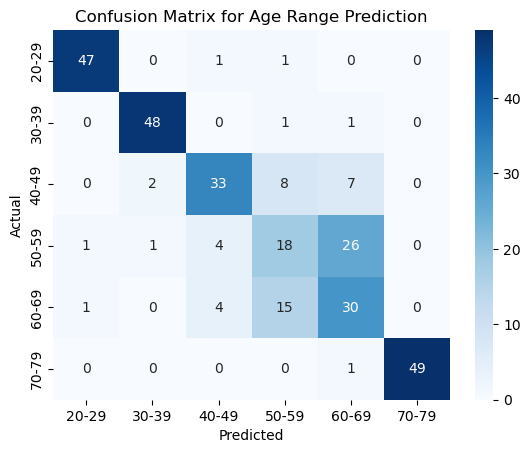

In [207]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Age Range Prediction')
plt.show()

XGBoost achieves comparable results with RandomForest but runs slower, so RandomForest is preferred. 

## Deep Learning Methods

In [216]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

# Now do train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# One-hot encode labels
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Build the MLP model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train
model.fit(X_train, y_train_cat, epochs=20, batch_size=32,
          validation_split=0.1, verbose=2)

# Evaluate
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred))

Epoch 1/20
34/34 - 1s - 27ms/step - accuracy: 0.3079 - loss: 21.7959 - val_accuracy: 0.4500 - val_loss: 10.8076
Epoch 2/20
34/34 - 1s - 19ms/step - accuracy: 0.4809 - loss: 13.6432 - val_accuracy: 0.5417 - val_loss: 8.9150
Epoch 3/20
34/34 - 1s - 19ms/step - accuracy: 0.5656 - loss: 9.7607 - val_accuracy: 0.5833 - val_loss: 5.2159
Epoch 4/20
34/34 - 1s - 19ms/step - accuracy: 0.5870 - loss: 7.7637 - val_accuracy: 0.6333 - val_loss: 3.9515
Epoch 5/20
34/34 - 1s - 19ms/step - accuracy: 0.6409 - loss: 6.0119 - val_accuracy: 0.6583 - val_loss: 4.5481
Epoch 6/20
34/34 - 1s - 19ms/step - accuracy: 0.7070 - loss: 4.4324 - val_accuracy: 0.6917 - val_loss: 3.7177
Epoch 7/20
34/34 - 1s - 19ms/step - accuracy: 0.7126 - loss: 3.6926 - val_accuracy: 0.7083 - val_loss: 2.6121
Epoch 8/20
34/34 - 1s - 19ms/step - accuracy: 0.7386 - loss: 3.2525 - val_accuracy: 0.6750 - val_loss: 3.3868
Epoch 9/20
34/34 - 1s - 19ms/step - accuracy: 0.7526 - loss: 2.7864 - val_accuracy: 0.7083 - val_loss: 2.3927
Epoch 1

0.8 seems to be the bottleneck of the multiclassification problem. Any alternative way to further improve the performance?